Cell 0 : SET UP (imports , paths , seeds , dirs )

In [1]:
# Cell 0 — Setup (imports, paths, seeds, dirs)

# ---- Core imports for data & training ----
import os, json, time, hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# Optional: if you still want to compare with python_speech_features
# from python_speech_features import mfcc as psf_mfcc

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ---- Reproducibility (use one seed everywhere) ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---- Project paths (works whether notebook is in Notebooks/ or not) ----
cwd = Path.cwd()
nb_names = {"Notebooks", "notebooks"}
PROJECT_ROOT = cwd.parent if cwd.name in nb_names else cwd

# Point to your dataset (adjust if needed)
AUDIO_ROOT = PROJECT_ROOT / "0_dB_fan" / "fan" / "id_00"     # contains normal/ and abnormal/
FEAT_DIR   = PROJECT_ROOT / "features"                       # raw features cache
PAD_DIR    = PROJECT_ROOT / "features_padded"                # padded/normalized features cache
MODEL_DIR  = PROJECT_ROOT / "model"                          # saved models & histories

# Create dirs if missing
for d in (FEAT_DIR, PAD_DIR, MODEL_DIR):
    d.mkdir(parents=True, exist_ok=True)

# ---- Default audio / MFCC parameters (edit later if you like) ----
SAMPLE_RATE     = 16000
CHUNK_DURATION  = 1.0     # seconds per chunk
N_MFCC          = 13
N_FILT          = 26
N_FFT           = 1024     # if you use python_speech_features

# Small sanity print so you always see where you are
print("PROJECT_ROOT:", PROJECT_ROOT)
print("AUDIO_ROOT  :", AUDIO_ROOT)
print("Dirs exist?  :", FEAT_DIR.exists(), PAD_DIR.exists(), MODEL_DIR.exists())
print("Seed         :", SEED)


c:\Users\hichr\OneDrive\Desktop\Internship\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\hichr\OneDrive\Desktop\Internship\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\hichr\OneDrive\Desktop\Internship\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.pr

PROJECT_ROOT: c:\Users\hichr\OneDrive\Desktop\Internship
AUDIO_ROOT  : c:\Users\hichr\OneDrive\Desktop\Internship\0_dB_fan\fan\id_00
Dirs exist?  : True True True
Seed         : 42


Load dataset and labels 

In [2]:
files, labels = [], []
for lab in ["normal", "abnormal"]:
    folder = AUDIO_ROOT / lab
    if not folder.exists():
        print(f"Warning: {folder} not found")
        continue
    for f in folder.glob("*.wav"):
        files.append(str(f))
        labels.append(0 if lab == "normal" else 1)


df = pd.DataFrame({"filename": files, "label": labels}).sort_values("filename").reset_index(drop=True)
print("Dataset loaded:", len(df), "files")
len(df), df.head()


Dataset loaded: 1418 files


(1418,
                                             filename  label
 0  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 1  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 2  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 3  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 4  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1)

new mfcc extraction 

In [4]:
# Cell 1 — MFCC (+Δ, Δ²) extraction with caching (librosa)

import os, json, hashlib
from pathlib import Path
import numpy as np
import librosa
from tqdm import tqdm

# Assumes: df (with columns: filename, label), FEAT_DIR, SAMPLE_RATE, CHUNK_DURATION, N_MFCC already defined
assert 'df' in globals(), "Run the file-listing cell first (build df)."
FEAT_DIR.mkdir(parents=True, exist_ok=True)

# --- Config (edit if needed) ---
sr = SAMPLE_RATE
chunk_sec = CHUNK_DURATION          # seconds per chunk (e.g., 1.0)
n_mfcc = N_MFCC                     # e.g., 13
include_deltas = True               # add Δ and Δ²
overlap = 0.0                       # 0.0 (no overlap), or 0.5 for 50% overlap, etc.
# --------------------------------

chunk_n = int(chunk_sec * sr)
hop_n = int(chunk_n * (1.0 - overlap)) if overlap > 0 else chunk_n

# Build a cache key from params + file manifest (size + mtime)
def file_sig(p: str):
    st = os.stat(p)
    return (str(p), int(st.st_size), int(st.st_mtime))

manifest = [file_sig(p) for p in df["filename"].tolist()]
manifest.sort()
key_src = json.dumps(
    {"sr": sr, "chunk_sec": chunk_sec, "n_mfcc": n_mfcc, "include_deltas": include_deltas, "overlap": overlap, "manifest": manifest},
    sort_keys=True
).encode()
cache_key = hashlib.md5(key_src).hexdigest()[:16]

cache_dir = FEAT_DIR / f"mfcc_cache_{cache_key}"
features_path = cache_dir / "features.npy"
labels_path   = cache_dir / "labels.npy"
meta_path     = cache_dir / "meta.json"

if features_path.exists() and labels_path.exists():
    print(f"✅ Using cached MFCCs: {cache_dir.name}")
    mfcc_features = np.load(features_path, allow_pickle=True)
    mfcc_labels   = np.load(labels_path)
else:
    print(f"🔍 Extracting MFCCs… deltas={include_deltas}, overlap={overlap}")
    cache_dir.mkdir(parents=True, exist_ok=True)

    feats, labs = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        x, _ = librosa.load(row["filename"], sr=sr, mono=True)

        # Slide over audio in fixed-size chunks
        for start in range(0, max(0, len(x) - chunk_n + 1), hop_n):
            seg = x[start:start + chunk_n]
            if len(seg) < chunk_n:
                continue

            m = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, frames)
            if include_deltas:
                d1 = librosa.feature.delta(m, order=1)
                d2 = librosa.feature.delta(m, order=2)
                m  = np.concatenate([m, d1, d2], axis=0)           # (n_mfcc*3, frames)

            feats.append(m.T.astype(np.float32))                   # (frames, features)
            labs.append(int(row["label"]))

    mfcc_features = np.array(feats, dtype=object)
    mfcc_labels   = np.array(labs, dtype=np.int32)

    np.save(features_path, mfcc_features)
    np.save(labels_path,   mfcc_labels)
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump({"sr": sr, "chunk_sec": chunk_sec, "n_mfcc": n_mfcc,
                   "include_deltas": include_deltas, "overlap": overlap,
                   "count": int(len(mfcc_features))}, f, indent=2)
    print(f"💾 Saved MFCC cache: {cache_dir.name}")

print("features:", len(mfcc_features), "labels:", len(mfcc_labels))
if len(mfcc_features):
    print("example feature shape:", mfcc_features[0].shape, "=(frames, features)")


🔍 Extracting MFCCs… deltas=True, overlap=0.0


100%|██████████| 1418/1418 [01:19<00:00, 17.91it/s]


💾 Saved MFCC cache: mfcc_cache_83fdfe1a53a7c33b
features: 14180 labels: 14180
example feature shape: (32, 39) =(frames, features)


mfcc trim / padding 

In [5]:
# Cell 2 — Pad/trim MFCC sequences to a uniform length (cached)

import json, hashlib
import numpy as np

assert 'mfcc_features' in globals() and 'mfcc_labels' in globals(), "Run Cell 1 first."
PAD_DIR.mkdir(parents=True, exist_ok=True)

# Choose your target length policy:
#   1) Use maximum length across samples (keeps all info, larger tensors)
#   2) Fix a cap like target_len = 120 (shorter, faster)
lengths = [arr.shape[0] for arr in mfcc_features]
target_len = max(lengths)  # change to a fixed int if you prefer a cap, e.g., 120

pad_meta = {"target_len": int(target_len), "strategy": "pad_or_trim_to_target"}
pad_key = hashlib.md5(json.dumps(pad_meta, sort_keys=True).encode()).hexdigest()[:10]
out_dir = PAD_DIR / f"padded_{pad_key}"
X_path, y_path = out_dir / "X.npy", out_dir / "y.npy"

if X_path.exists() and y_path.exists():
    print(f"✅ Using cached padded set: {out_dir.name}")
    X = np.load(X_path)
    y = np.load(y_path)
else:
    out_dir.mkdir(parents=True, exist_ok=True)
    padded = []
    for feat in mfcc_features:
        t = feat.shape[0]
        if t < target_len:
            pad = np.pad(feat, ((0, target_len - t), (0, 0)), mode="constant")
        else:
            pad = feat[:target_len]
        padded.append(pad.astype(np.float32))

    X = np.asarray(padded, dtype=np.float32)   # (N, timesteps, features)
    y = np.asarray(mfcc_labels, dtype=np.int32)

    np.save(X_path, X)
    np.save(y_path, y)
    with open(out_dir / "meta.json", "w", encoding="utf-8") as f:
        json.dump({"target_len": target_len, "n_samples": int(len(X))}, f, indent=2)
    print(f"💾 Saved padded set: {out_dir.name} (target_len={target_len})")

print("X shape:", X.shape, "y shape:", y.shape)


💾 Saved padded set: padded_145ed1c563 (target_len=32)
X shape: (14180, 32, 39) y shape: (14180,)


train/test/val split 

In [6]:
# Cell 3 — Split (+ dtype) and optional normalization
from sklearn.model_selection import train_test_split
import numpy as np

TEST_SIZE = 0.20
VAL_SIZE  = 0.20
NORMALIZE = True  # set False to disable

# 1) Train+Val vs Test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

# 2) Train vs Val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SIZE, random_state=42, stratify=y_trainval
)

# Dtypes for Keras
X_train = X_train.astype(np.float32); X_val = X_val.astype(np.float32); X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32);   y_val = y_val.astype(np.int32);   y_test = y_test.astype(np.int32)

# Optional: per-feature standardization (fit on TRAIN only)
if NORMALIZE:
    fmean = X_train.reshape(-1, X_train.shape[-1]).mean(axis=0)
    fstd  = X_train.reshape(-1, X_train.shape[-1]).std(axis=0) + 1e-8
    X_train = (X_train - fmean) / fstd
    X_val   = (X_val   - fmean) / fstd
    X_test  = (X_test  - fmean) / fstd

def counts(y):
    u, c = np.unique(y, return_counts=True)
    return dict(zip(u.astype(int), c.astype(int)))

print(f"Train: {X_train.shape}  Val: {X_val.shape}  Test: {X_test.shape}")
print("Train labels:", counts(y_train))
print("Val labels:  ", counts(y_val))
print("Test labels: ", counts(y_test))


Train: (9075, 32, 39)  Val: (2269, 32, 39)  Test: (2836, 32, 39)
Train labels: {np.int64(0): np.int64(6470), np.int64(1): np.int64(2605)}
Val labels:   {np.int64(0): np.int64(1618), np.int64(1): np.int64(651)}
Test labels:  {np.int64(0): np.int64(2022), np.int64(1): np.int64(814)}


build model 

CELL S : Static Setup (imports , seeds , helpers )

In [7]:
# === Cell S — Static setup (run once) ===
import os, json, time
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass  # ok if not available on your TF build

# Paths
MODEL_DIR = Path(PROJECT_ROOT) / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def build_model(input_shape, params, use_gap=False):
    """Builds and compiles a fresh 1D-CNN for MFCC sequences."""
    tf.keras.backend.clear_session()
    l2 = params.get("l2", 0.0)

    def l2_or_none():
        return regularizers.l2(l2) if l2 and l2 > 0 else None

    m = Sequential([
        layers.Input(shape=input_shape),

        layers.Conv1D(params["f1"], 5, padding="same", activation="relu",
                      kernel_initializer="he_normal", use_bias=False, kernel_regularizer=l2_or_none()),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(params["drop1"]),

        layers.Conv1D(params["f2"], 3, padding="same", activation="relu",
                      kernel_initializer="he_normal", use_bias=False, kernel_regularizer=l2_or_none()),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(params["drop2"]),

        layers.Conv1D(params["f3"], 3, padding="same", activation="relu",
                      kernel_initializer="he_normal", use_bias=False, kernel_regularizer=l2_or_none()),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(params["drop3"]),

        layers.GlobalAveragePooling1D() if use_gap else layers.Flatten(),

        layers.Dense(params["dense"], activation="relu",
                     kernel_initializer="he_normal",
                     kernel_regularizer=l2_or_none()),
        layers.Dropout(params["drop_dense"]),
        layers.Dense(1, activation="sigmoid"),
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=params["lr"], clipnorm=1.0)
    m.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.AUC(curve="PR", name="auprc"),
        ],
    )
    return m

def compute_cw(y):
    """Balanced class weights from labels."""
    classes = np.array(sorted(np.unique(y)))
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    return {int(c): float(w) for c, w in zip(classes, cw)}

def make_callbacks(run_id):
    """EarlyStopping, ReduceLROnPlateau, and unique checkpoint."""
    ckpt_path = MODEL_DIR / f"best_mfcc_1dcnn_{run_id}.keras"
    cbs = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]
    return cbs, ckpt_path


cell R : Per-run hyperparams + fresh model + callbacks + train (rerun each experiment) 

In [8]:
# === Cell R — Per-run hyperparams + fresh model + callbacks + train (rerun each experiment) ===
import json, time
import numpy as np

params = {
    "f1": 64, "f2": 128, "f3": 128,
    "drop1": 0.25, "drop2": 0.25, "drop3": 0.25,
    "dense": 128, "drop_dense": 0.40,
    "lr": 1e-3,
    "l2": 0.0,     # try 1e-4 if overfitting
}
USE_GAP = False   # try True if Flatten overfits

run_id = time.strftime("%Y%m%d-%H%M%S")
callbacks, ckpt_path = make_callbacks(run_id)

input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = build_model(input_shape, params, use_gap=USE_GAP)
model.summary()

class_weight_dict = compute_cw(y_train)
print("Class weights:", class_weight_dict)
print("Checkpoint path:", ckpt_path)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train labels:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Val labels:  ", dict(zip(*np.unique(y_val, return_counts=True))))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# Save history + params used for this run
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({"history": history.history, "params": params, "use_gap": USE_GAP}, f, indent=2)

print(f"✅ Saved history: {hist_path}")
print(f"✅ Best checkpoint: {ckpt_path}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 64)         │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 128)        │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,281 (598.75 KB)

 Trainable params: 152,641 (596.25 KB)

 Non-trainable params: 640 (2.50 KB)

Class weights: {0: 0.7013137557959814, 1: 1.7418426103646834}
Checkpoint path: c:\Users\hichr\OneDrive\Desktop\Internship\model\best_mfcc_1dcnn_20250813-093125.keras
Train: (9075, 32, 39) Val: (2269, 32, 39) Test: (2836, 32, 39)
Train labels: {np.int32(0): np.int64(6470), np.int32(1): np.int64(2605)}
Val labels:   {np.int32(0): np.int64(1618), np.int32(1): np.int64(651)}
Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6601 - auc: 0.7094 - auprc: 0.5170 - loss: 0.7197 - val_accuracy: 0.7078 - val_auc: 0.8128 - val_auprc: 0.7283 - val_loss: 0.5566 - learning_rate: 0.0010
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7482 - auc: 0.8149 - auprc: 0.7108 - loss: 0.5213 - val_accuracy: 0.7669 - val_auc: 0.8488 - val_auprc: 0.7745 - val_loss: 0.4882 - learning_rate: 0.0010
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7849 - auc: 0.8533 - auprc: 0.7638 - loss: 0.4678 - val_accuracy: 0.8167 - val_auc: 0.8816 - val_auprc: 0.8182 - val_

plot training curves 

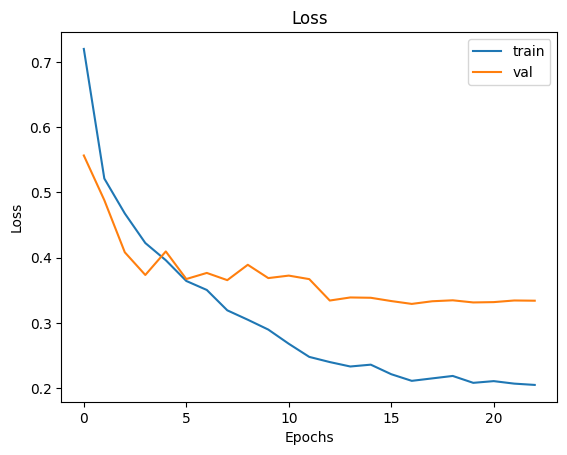

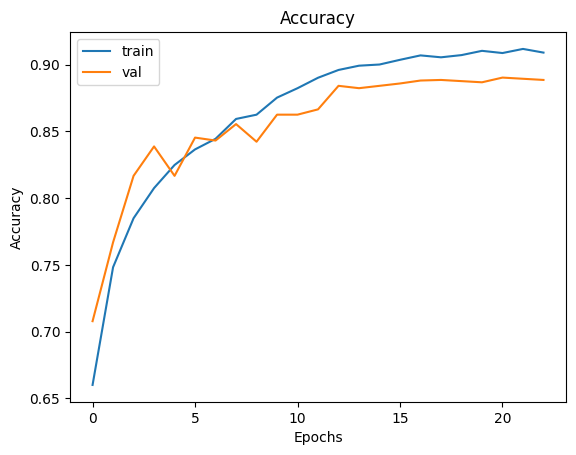

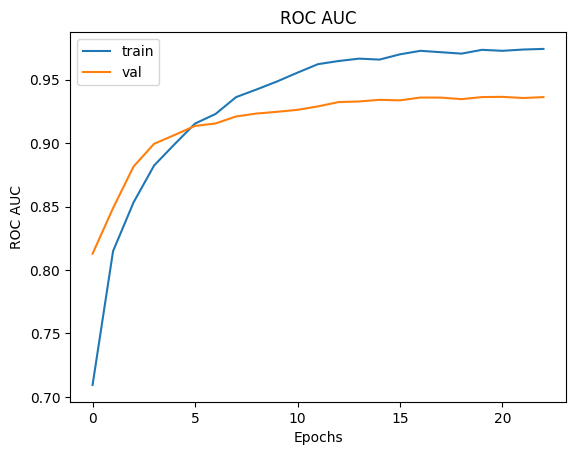

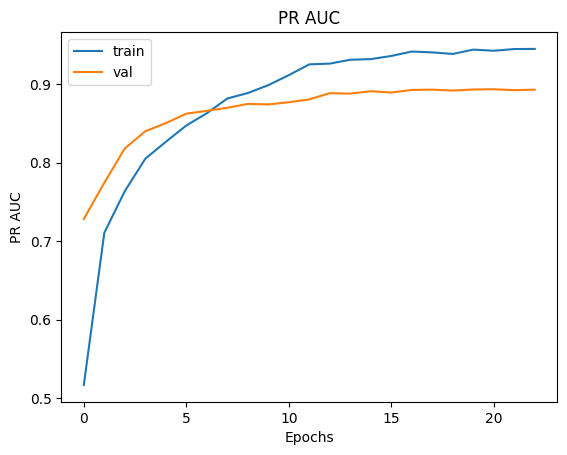

In [10]:
# === Cell 1: Plot training curves ===
import json, matplotlib.pyplot as plt

# Use your actual history path if needed
with open(hist_path, "r", encoding="utf-8") as f:
    history_data = json.load(f)
history = history_data["history"] if "history" in history_data else history_data

def plot_train_val(metric, label=None):
    plt.figure()
    plt.plot(history[metric], label="train")
    plt.plot(history["val_" + metric], label="val")
    plt.title(label or metric)
    plt.xlabel("Epochs")
    plt.ylabel(label or metric)
    plt.legend()
    plt.show()

plot_train_val("loss", "Loss")
if "accuracy" in history: plot_train_val("accuracy", "Accuracy")
if "auc" in history:      plot_train_val("auc", "ROC AUC")
if "auprc" in history:    plot_train_val("auprc", "PR AUC")


Cell 2: Evaluate on test set (default threshold = 0.5)

In [11]:
# === Cell 2: Evaluate on test set (default threshold = 0.5) ===
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)

# Load saved model from training
best_model = tf.keras.models.load_model(ckpt_path)

# Raw Keras evaluation
test_results = best_model.evaluate(X_test, y_test, return_dict=True, verbose=0)
print("✅ Keras metrics on test:", test_results)

# Get model probabilities
y_prob = best_model.predict(X_test, verbose=0).ravel()

# Threshold-independent metrics
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"🎯 ROC-AUC: {roc_auc:.4f}")
print(f"🎯 PR-AUC : {pr_auc:.4f}")

# Evaluate at default threshold = 0.5
y_pred_05 = (y_prob >= 0.5).astype(int)
print("📊 Confusion matrix @ 0.5:\n", confusion_matrix(y_test, y_pred_05))
print("📝 Classification report @ 0.5:\n", classification_report(y_test, y_pred_05, digits=4))


✅ Keras metrics on test: {'accuracy': 0.8917489647865295, 'auc': 0.9356589913368225, 'auprc': 0.8877228498458862, 'loss': 0.3401011824607849}
🎯 ROC-AUC: 0.9399
🎯 PR-AUC : 0.9001
📊 Confusion matrix @ 0.5:
 [[1850  172]
 [ 135  679]]
📝 Classification report @ 0.5:
               precision    recall  f1-score   support

           0     0.9320    0.9149    0.9234      2022
           1     0.7979    0.8342    0.8156       814

    accuracy                         0.8917      2836
   macro avg     0.8649    0.8745    0.8695      2836
weighted avg     0.8935    0.8917    0.8925      2836



✅ Best F1 = 0.8290 at threshold = 0.6350
✅ Best Youden's J = 0.7544 at threshold = 0.6350

📌 Final evaluation @ threshold = 0.6350
Confusion:
 [[1898  124]
 [ 150  664]]
Report:
               precision    recall  f1-score   support

           0     0.9268    0.9387    0.9327      2022
           1     0.8426    0.8157    0.8290       814

    accuracy                         0.9034      2836
   macro avg     0.8847    0.8772    0.8808      2836
weighted avg     0.9026    0.9034    0.9029      2836



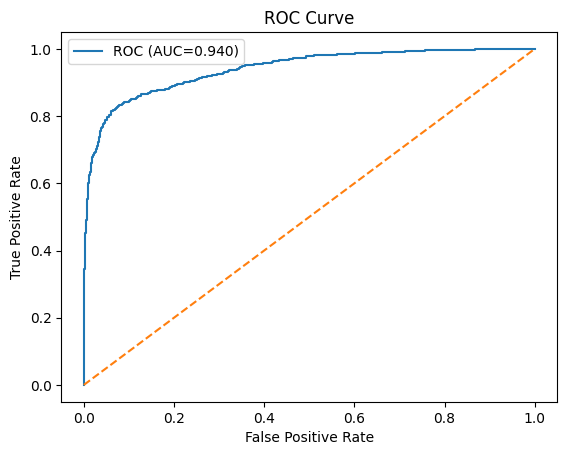

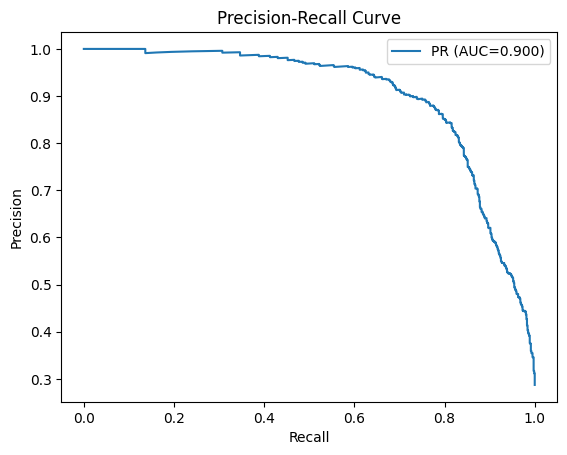

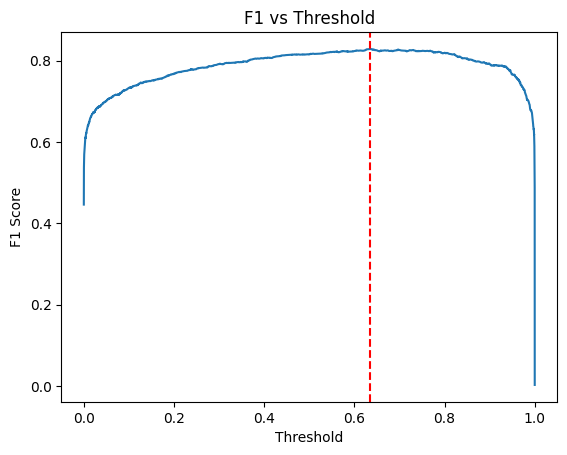

In [12]:
# === Cell 3: Threshold tuning + ROC/PR/F1 plots ===
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
import matplotlib.pyplot as plt

# 1) F1-optimal threshold
prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
ths = np.r_[0.0, thr_pr]  # pad to match lengths
f1s = [f1_score(y_test, (y_prob >= t).astype(int)) for t in ths]
best_f1_idx = int(np.argmax(f1s))
best_t_f1 = float(ths[best_f1_idx])
print(f"✅ Best F1 = {f1s[best_f1_idx]:.4f} at threshold = {best_t_f1:.4f}")

# 2) Youden's J
fpr, tpr, thr_roc = roc_curve(y_test, y_prob)
youden = tpr - fpr
best_j_idx = int(np.argmax(youden))
best_t_j = float(thr_roc[best_j_idx])
print(f"✅ Best Youden's J = {youden[best_j_idx]:.4f} at threshold = {best_t_j:.4f}")

# 3) Choose threshold
chosen_t = best_t_f1  # or best_t_j
y_pred = (y_prob >= chosen_t).astype(int)

# Final metrics
print(f"\n📌 Final evaluation @ threshold = {chosen_t:.4f}")
print("Confusion:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred, digits=4))

# 4) Plots
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

plt.figure()
plt.plot(rec, prec, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(); plt.show()

plt.figure()
plt.plot(ths, f1s)
plt.xlabel("Threshold"); plt.ylabel("F1 Score")
plt.title("F1 vs Threshold"); plt.axvline(chosen_t, color='r', linestyle='--')
plt.show()


** ENHANCEMENT ** : Step 1 : Step 1: Model Exploration Phase is complete.

Cell R-V2   


In [13]:
# === Cell R-V2 — Per-run hyperparams + fresh model + callbacks + train (rerun each experiment) ===
import json, time
import numpy as np

params = {
    "f1": 64, "f2": 128, "f3": 128,
    "drop1": 0.25, "drop2": 0.25, "drop3": 0.25,
    "dense": 128, "drop_dense": 0.50, ## try 0.5 
    "lr": 1e-3,
    "l2": 1e-4,     # # try 1e-4 if overfitting
}
USE_GAP = True   # # Changing it to TRUE 

run_id = time.strftime("%Y%m%d-%H%M%S")
callbacks, ckpt_path = make_callbacks(run_id)

input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = build_model(input_shape, params, use_gap=USE_GAP)
model.summary()

class_weight_dict = compute_cw(y_train)
print("Class weights:", class_weight_dict)
print("Checkpoint path:", ckpt_path)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train labels:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Val labels:  ", dict(zip(*np.unique(y_val, return_counts=True))))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# Save history + params used for this run
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({"history": history.history, "params": params, "use_gap": USE_GAP}, f, indent=2)

print(f"✅ Saved history: {hist_path}")
print(f"✅ Best checkpoint: {ckpt_path}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 64)         │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 128)        │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,129 (406.75 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 640 (2.50 KB)

Class weights: {0: 0.7013137557959814, 1: 1.7418426103646834}
Checkpoint path: c:\Users\hichr\OneDrive\Desktop\Internship\model\best_mfcc_1dcnn_20250813-150528.keras
Train: (9075, 32, 39) Val: (2269, 32, 39) Test: (2836, 32, 39)
Train labels: {np.int32(0): np.int64(6470), np.int32(1): np.int64(2605)}
Val labels:   {np.int32(0): np.int64(1618), np.int32(1): np.int64(651)}
Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6712 - auc: 0.7350 - auprc: 0.5794 - loss: 0.7280 - val_accuracy: 0.7885 - val_auc: 0.8303 - val_auprc: 0.7490 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7494 - auc: 0.8200 - auprc: 0.7214 - loss: 0.6022 - val_accuracy: 0.8123 - val_auc: 0.8776 - val_auprc: 0.8039 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7934 - auc: 0.8699 - auprc: 0.7868 - loss: 0.5331 - val_accuracy: 0.8352 - val_auc: 0.9049 - val_auprc: 0.8485 - val_lo

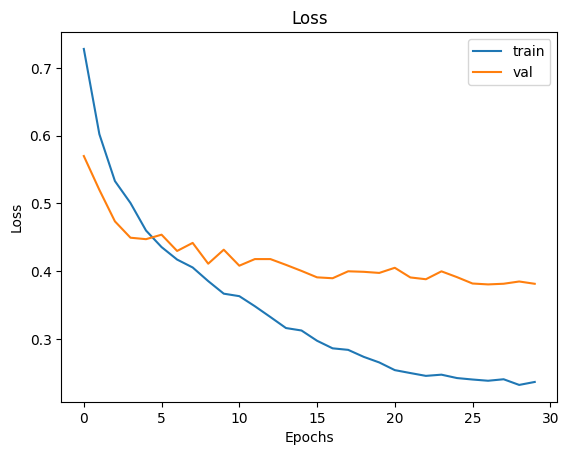

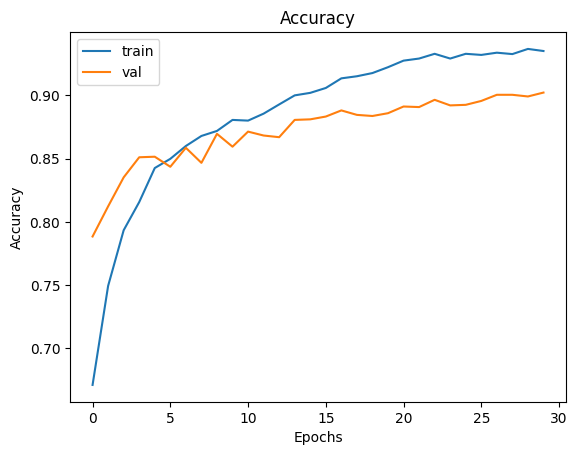

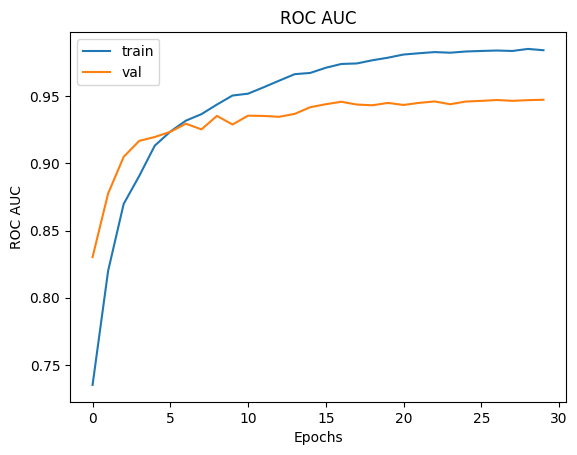

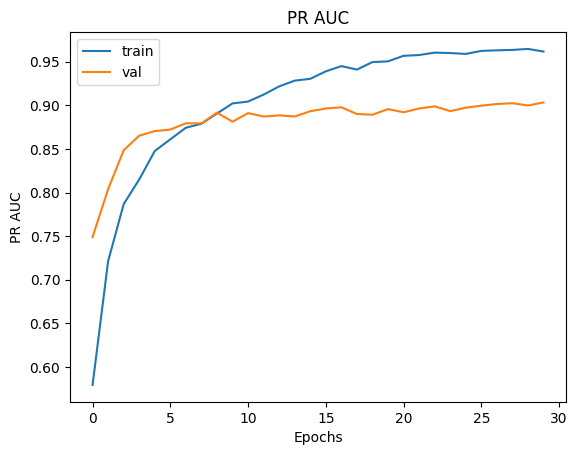

In [14]:
# === Cell 1: Plot training curves ===
import json, matplotlib.pyplot as plt

# Use your actual history path if needed
with open(hist_path, "r", encoding="utf-8") as f:
    history_data = json.load(f)
history = history_data["history"] if "history" in history_data else history_data

def plot_train_val(metric, label=None):
    plt.figure()
    plt.plot(history[metric], label="train")
    plt.plot(history["val_" + metric], label="val")
    plt.title(label or metric)
    plt.xlabel("Epochs")
    plt.ylabel(label or metric)
    plt.legend()
    plt.show()

plot_train_val("loss", "Loss")
if "accuracy" in history: plot_train_val("accuracy", "Accuracy")
if "auc" in history:      plot_train_val("auc", "ROC AUC")
if "auprc" in history:    plot_train_val("auprc", "PR AUC")


In [15]:
# === Cell 2: Evaluate on test set (default threshold = 0.5) ===
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)

# Load saved model from training
best_model = tf.keras.models.load_model(ckpt_path)

# Raw Keras evaluation
test_results = best_model.evaluate(X_test, y_test, return_dict=True, verbose=0)
print("✅ Keras metrics on test:", test_results)

# Get model probabilities
y_prob = best_model.predict(X_test, verbose=0).ravel()

# Threshold-independent metrics
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"🎯 ROC-AUC: {roc_auc:.4f}")
print(f"🎯 PR-AUC : {pr_auc:.4f}")

# Evaluate at default threshold = 0.5
y_pred_05 = (y_prob >= 0.5).astype(int)
print("📊 Confusion matrix @ 0.5:\n", confusion_matrix(y_test, y_pred_05))
print("📝 Classification report @ 0.5:\n", classification_report(y_test, y_pred_05, digits=4))


✅ Keras metrics on test: {'accuracy': 0.9044429063796997, 'auc': 0.9459335207939148, 'auprc': 0.9010792970657349, 'loss': 0.38684147596359253}
🎯 ROC-AUC: 0.9510
🎯 PR-AUC : 0.9126
📊 Confusion matrix @ 0.5:
 [[1870  152]
 [ 119  695]]
📝 Classification report @ 0.5:
               precision    recall  f1-score   support

           0     0.9402    0.9248    0.9324      2022
           1     0.8205    0.8538    0.8368       814

    accuracy                         0.9044      2836
   macro avg     0.8804    0.8893    0.8846      2836
weighted avg     0.9058    0.9044    0.9050      2836



✅ Best F1 = 0.8432 at threshold = 0.7502
✅ Best Youden's J = 0.7833 at threshold = 0.4480

📌 Final evaluation @ threshold = 0.7502
Confusion:
 [[1936   86]
 [ 158  656]]
Report:
               precision    recall  f1-score   support

           0     0.9245    0.9575    0.9407      2022
           1     0.8841    0.8059    0.8432       814

    accuracy                         0.9140      2836
   macro avg     0.9043    0.8817    0.8920      2836
weighted avg     0.9129    0.9140    0.9127      2836



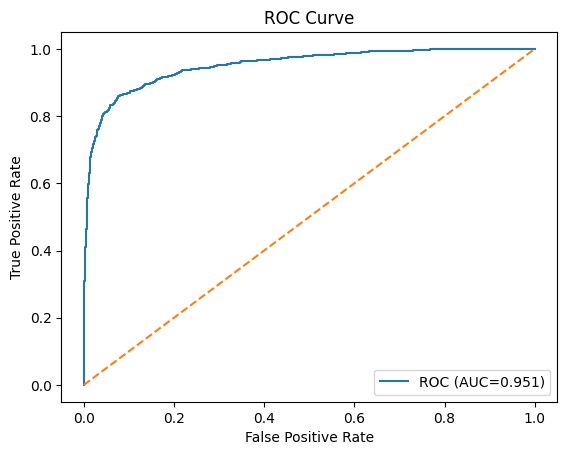

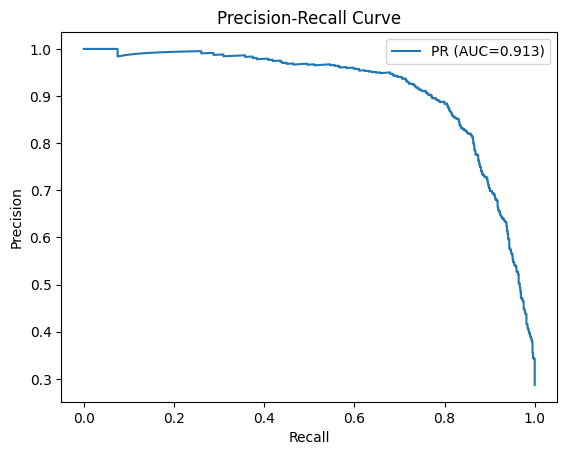

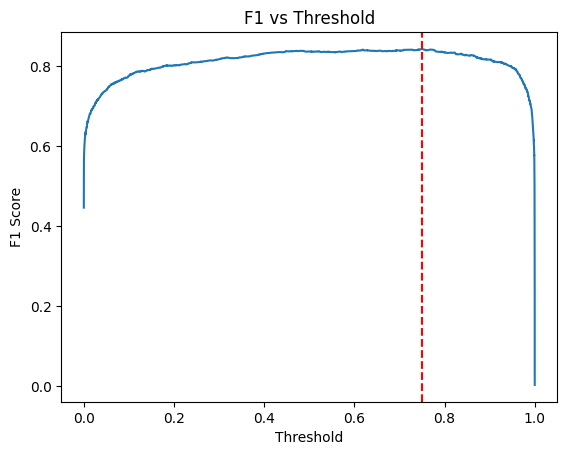

In [16]:
# === Cell 3: Threshold tuning + ROC/PR/F1 plots ===
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
import matplotlib.pyplot as plt

# 1) F1-optimal threshold
prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
ths = np.r_[0.0, thr_pr]  # pad to match lengths
f1s = [f1_score(y_test, (y_prob >= t).astype(int)) for t in ths]
best_f1_idx = int(np.argmax(f1s))
best_t_f1 = float(ths[best_f1_idx])
print(f"✅ Best F1 = {f1s[best_f1_idx]:.4f} at threshold = {best_t_f1:.4f}")

# 2) Youden's J
fpr, tpr, thr_roc = roc_curve(y_test, y_prob)
youden = tpr - fpr
best_j_idx = int(np.argmax(youden))
best_t_j = float(thr_roc[best_j_idx])
print(f"✅ Best Youden's J = {youden[best_j_idx]:.4f} at threshold = {best_t_j:.4f}")

# 3) Choose threshold
chosen_t = best_t_f1  # or best_t_j
y_pred = (y_prob >= chosen_t).astype(int)

# Final metrics
print(f"\n📌 Final evaluation @ threshold = {chosen_t:.4f}")
print("Confusion:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred, digits=4))

# 4) Plots
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

plt.figure()
plt.plot(rec, prec, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(); plt.show()

plt.figure()
plt.plot(ths, f1s)
plt.xlabel("Threshold"); plt.ylabel("F1 Score")
plt.title("F1 vs Threshold"); plt.axvline(chosen_t, color='r', linestyle='--')
plt.show()


STEP 2 : Feature Impact Phase

In [6]:
# 🔁 FBank (Log Mel Spectrogram) extraction with caching (librosa)

import os, json, hashlib
from pathlib import Path
import numpy as np
import librosa
from tqdm import tqdm

# Assumes: df (with columns: filename, label), FEAT_DIR, SAMPLE_RATE, CHUNK_DURATION, N_MFCC already defined
assert 'df' in globals(), "Run the file-listing cell first (build df)."
FEAT_DIR.mkdir(parents=True, exist_ok=True)

# --- Config (edit if needed) ---
sr = SAMPLE_RATE
chunk_sec = CHUNK_DURATION          # seconds per chunk (e.g., 1.0)
n_mels = N_MFCC                     # number of Mel filters (same as n_mfcc for consistency)
overlap = 0.0                       # 0.0 (no overlap), or 0.5 for 50% overlap, etc.
# --------------------------------

chunk_n = int(chunk_sec * sr)
hop_n = int(chunk_n * (1.0 - overlap)) if overlap > 0 else chunk_n

# Cache signature to avoid recomputing
def file_sig(p: str):
    st = os.stat(p)
    return (str(p), int(st.st_size), int(st.st_mtime))

manifest = [file_sig(p) for p in df["filename"].tolist()]
manifest.sort()
key_src = json.dumps(
    {"sr": sr, "chunk_sec": chunk_sec, "n_mels": n_mels, "type": "fbank", "overlap": overlap, "manifest": manifest},
    sort_keys=True
).encode()
cache_key = hashlib.md5(key_src).hexdigest()[:16]

cache_dir = FEAT_DIR / f"fbank_cache_{cache_key}"
features_path = cache_dir / "features.npy"
labels_path   = cache_dir / "labels.npy"
meta_path     = cache_dir / "meta.json"

if features_path.exists() and labels_path.exists():
    print(f"✅ Using cached FBank features: {cache_dir.name}")
    fbank_features = np.load(features_path, allow_pickle=True)
    fbank_labels   = np.load(labels_path)
else:
    print(f"🔍 Extracting FBank features… overlap={overlap}")
    cache_dir.mkdir(parents=True, exist_ok=True)

    feats, labs = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        x, _ = librosa.load(row["filename"], sr=sr, mono=True)

        for start in range(0, max(0, len(x) - chunk_n + 1), hop_n):
            seg = x[start:start + chunk_n]
            if len(seg) < chunk_n:
                continue

            # Extract FBank (log-Mel)
            mel_spec = librosa.feature.melspectrogram(y=seg, sr=sr, n_mels=n_mels, fmax=sr // 2)
            log_mel  = librosa.power_to_db(mel_spec)

            feats.append(log_mel.T.astype(np.float32))  # (frames, features)
            labs.append(int(row["label"]))

    fbank_features = np.array(feats, dtype=object)
    fbank_labels   = np.array(labs, dtype=np.int32)

    np.save(features_path, fbank_features)
    np.save(labels_path,   fbank_labels)
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump({"sr": sr, "chunk_sec": chunk_sec, "n_mels": n_mels,
                   "overlap": overlap, "count": int(len(fbank_features))}, f, indent=2)
    print(f"💾 Saved FBank cache: {cache_dir.name}")

print("features:", len(fbank_features), "labels:", len(fbank_labels))
if len(fbank_features):
    print("example feature shape:", fbank_features[0].shape, "=(frames, features)")


✅ Using cached FBank features: fbank_cache_23399b29ec9aaf54
features: 14180 labels: 14180
example feature shape: (32, 13) =(frames, features)


In [8]:
# Cell — Pad/trim FBank sequences to a uniform length (cached)

import json, hashlib
import numpy as np

assert 'fbank_features' in globals() and 'fbank_labels' in globals(), "Run FBank extraction cell first."
PAD_DIR.mkdir(parents=True, exist_ok=True)

# Choose your target length policy:
lengths = [arr.shape[0] for arr in fbank_features]
target_len = max(lengths)  # or set a fixed value like 120

pad_meta = {"target_len": int(target_len), "strategy": "pad_or_trim_to_target"}
pad_key = hashlib.md5(json.dumps(pad_meta, sort_keys=True).encode()).hexdigest()[:10]
out_dir = PAD_DIR / f"fbank_padded_{pad_key}"  # renamed for clarity
X_path, y_path = out_dir / "X.npy", out_dir / "y.npy"

if X_path.exists() and y_path.exists():
    print(f"✅ Using cached padded set: {out_dir.name}")
    X = np.load(X_path)
    y = np.load(y_path)
else:
    out_dir.mkdir(parents=True, exist_ok=True)
    padded = []
    for feat in fbank_features:
        t = feat.shape[0]
        if t < target_len:
            pad = np.pad(feat, ((0, target_len - t), (0, 0)), mode="constant")
        else:
            pad = feat[:target_len]
        padded.append(pad.astype(np.float32))

    X = np.asarray(padded, dtype=np.float32)   # (N, timesteps, features)
    y = np.asarray(fbank_labels, dtype=np.int32)

    np.save(X_path, X)
    np.save(y_path, y)
    with open(out_dir / "meta.json", "w", encoding="utf-8") as f:
        json.dump({"target_len": target_len, "n_samples": int(len(X))}, f, indent=2)
    print(f"💾 Saved padded set: {out_dir.name} (target_len={target_len})")

print("X shape:", X.shape, "y shape:", y.shape)


✅ Using cached padded set: fbank_padded_145ed1c563
X shape: (14180, 32, 13) y shape: (14180,)


check class distribution

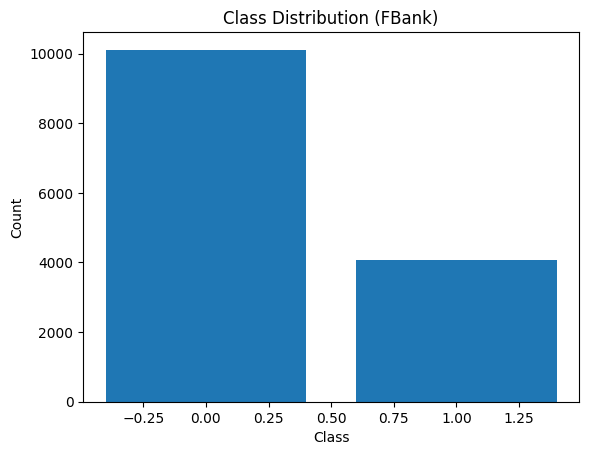

In [7]:
import numpy as np
import matplotlib.pyplot as plt

classes, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts)
plt.title("Class Distribution (FBank)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (9926, 32, 13)
Val: (2127, 32, 13)
Test: (2127, 32, 13)


cell S'' fbank 

In [9]:
# === Cell S — Static setup (run once) ===
import os, json, time
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass  # ok if not available on your TF build

# Paths
MODEL_DIR = Path(PROJECT_ROOT) / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def build_model(input_shape, params, use_gap=False):
    """Builds and compiles a fresh 1D-CNN for MFCC sequences."""
    tf.keras.backend.clear_session()
    l2 = params.get("l2", 0.0)

    def l2_or_none():
        return regularizers.l2(l2) if l2 and l2 > 0 else None

    m = Sequential([
        layers.Input(shape=input_shape),

        layers.Conv1D(params["f1"], 5, padding="same", activation="relu",
                      kernel_initializer="he_normal", use_bias=False, kernel_regularizer=l2_or_none()),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(params["drop1"]),

        layers.Conv1D(params["f2"], 3, padding="same", activation="relu",
                      kernel_initializer="he_normal", use_bias=False, kernel_regularizer=l2_or_none()),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(params["drop2"]),

        layers.Conv1D(params["f3"], 3, padding="same", activation="relu",
                      kernel_initializer="he_normal", use_bias=False, kernel_regularizer=l2_or_none()),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(params["drop3"]),

        layers.GlobalAveragePooling1D() if use_gap else layers.Flatten(),

        layers.Dense(params["dense"], activation="relu",
                     kernel_initializer="he_normal",
                     kernel_regularizer=l2_or_none()),
        layers.Dropout(params["drop_dense"]),
        layers.Dense(1, activation="sigmoid"),
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=params["lr"], clipnorm=1.0)
    m.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.AUC(curve="PR", name="auprc"),
        ],
    )
    return m

def compute_cw(y):
    """Balanced class weights from labels."""
    classes = np.array(sorted(np.unique(y)))
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    return {int(c): float(w) for c, w in zip(classes, cw)}

def make_callbacks(run_id):
    """EarlyStopping, ReduceLROnPlateau, and unique checkpoint."""
    ckpt_path = MODEL_DIR / f"best_fbank_1dcnn_{run_id}.keras"
    cbs = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]
    return cbs, ckpt_path


Cell R''


In [10]:
# === Cell R — Train a fresh 1D-CNN with FBank features ===

import json, time
import numpy as np

# 💡 Hyperparameters — can be tuned later
params = {
    "f1": 64, "f2": 128, "f3": 128,
    "drop1": 0.25, "drop2": 0.25, "drop3": 0.25,
    "dense": 128, "drop_dense": 0.40,
    "lr": 1e-3,
    "l2": 0.0,  # You can try 1e-4 if overfitting
}
USE_GAP = False  # You can try True if Flatten causes overfitting

# ✅ Identify the run clearly as FBank
run_id = time.strftime("fbank_%Y%m%d-%H%M%S")  # NEW: prefix to track runs
callbacks, ckpt_path = make_callbacks(run_id)  # ckpt path uses the updated run_id

# 📐 Input shape for model = (time_steps, n_mels)
input_shape = (X_train.shape[1], X_train.shape[2])  # no change

# 🏗️ Build a fresh 1D CNN
model = build_model(input_shape, params, use_gap=USE_GAP)
model.summary()

# ⚖️ Compute class weights
class_weight_dict = compute_cw(y_train)
print("Class weights:", class_weight_dict)
print("Checkpoint path:", ckpt_path)

# 🧾 Show data split info
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train labels:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Val labels:  ", dict(zip(*np.unique(y_val, return_counts=True))))

# 🏋️‍♀️ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# 💾 Save training history and params
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({"history": history.history, "params": params, "use_gap": USE_GAP}, f, indent=2)

print(f"✅ Saved history: {hist_path}")
print(f"✅ Best checkpoint: {ckpt_path}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 128)        │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,961 (566.25 KB)

 Trainable params: 144,321 (563.75 KB)

 Non-trainable params: 640 (2.50 KB)

Class weights: {0: 0.7012858555885262, 1: 1.742014742014742}
Checkpoint path: c:\Users\hichr\OneDrive\Desktop\Internship\model\best_fbank_1dcnn_fbank_20250819-120322.keras
Train: (9926, 32, 13) Val: (2127, 32, 13) Test: (2127, 32, 13)
Train labels: {np.int32(0): np.int64(7077), np.int32(1): np.int64(2849)}
Val labels:   {np.int32(0): np.int64(1516), np.int32(1): np.int64(611)}
Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6866 - auc: 0.6823 - auprc: 0.5735 - loss: 0.6704 - val_accuracy: 0.2873 - val_auc: 0.3610 - val_auprc: 0.2440 - val_loss: 1.8377 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7769 - auc: 0.7311 - auprc: 0.6655 - loss: 0.5560 - val_accuracy: 0.6808 - val_auc: 0.5177 - val_auprc: 0.3625 - val_loss: 0.6537 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7874 - auc: 0.7659 - auprc: 0.6957 - loss: 0.5351 - val_accuracy: 0.7348 - val_auc: 0.6468 - val_auprc: 0.5008 - 

Evaluation 

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict class labels
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
[[1426   91]
 [ 299  311]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8267    0.9400    0.8797      1517
           1     0.7736    0.5098    0.6146       610

    accuracy                         0.8166      2127
   macro avg     0.8001    0.7249    0.7472      2127
weighted avg     0.8115    0.8166    0.8037      2127

ROC-AUC Score: 0.819981196710505


✅ 📦 Step 1 — Threshold Tuning Cell (drop this after training)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔍 Best F1 = 0.6552 at threshold = 0.445


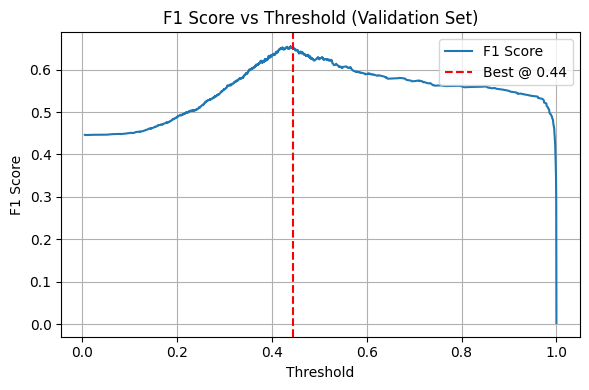

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Evaluation on TEST set @ best threshold
Confusion Matrix:
[[1340  177]
 [ 234  376]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8513    0.8833    0.8670      1517
           1     0.6799    0.6164    0.6466       610

    accuracy                         0.8068      2127
   macro avg     0.7656    0.7499    0.7568      2127
weighted avg     0.8022    0.8068    0.8038      2127

ROC-AUC: 0.819981196710505


In [12]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# === STEP 1A — Get predicted probabilities on validation set
y_val_proba = model.predict(X_val).ravel()

# === STEP 1B — Find the threshold that gives the best F1-score
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)

best_idx = np.argmax(f1)
best_thr = thr[best_idx]

print(f"🔍 Best F1 = {f1[best_idx]:.4f} at threshold = {best_thr:.3f}")

# === STEP 1C — Plot F1 vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thr, f1[:-1], label="F1 Score")
plt.axvline(best_thr, color='r', linestyle='--', label=f"Best @ {best_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (Validation Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 1D — Evaluate on test set with best threshold
y_test_proba = model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= best_thr).astype(int)

print("✅ Evaluation on TEST set @ best threshold")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))


STEP 2 – Retrain with Generalization Boosters

In [13]:
# === Cell R — Improved Retraining with L2 + GAP ===
import json, time
import numpy as np

params = {
    "f1": 64, "f2": 128, "f3": 128,
    "drop1": 0.25, "drop2": 0.25, "drop3": 0.25,
    "dense": 128, "drop_dense": 0.40,
    "lr": 1e-3,
    "l2": 1e-4,     # 💡 Added L2 regularization
}
USE_GAP = True      # 💡 Replaced Flatten with GAP

run_id = time.strftime("gap_l2_%Y%m%d-%H%M%S")
callbacks, ckpt_path = make_callbacks(run_id)

input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = build_model(input_shape, params, use_gap=USE_GAP)
model.summary()

class_weight_dict = compute_cw(y_train)
print("Class weights:", class_weight_dict)
print("Checkpoint path:", ckpt_path)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train labels:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Val labels:  ", dict(zip(*np.unique(y_val, return_counts=True))))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# Save history + params used for this run
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({"history": history.history, "params": params, "use_gap": USE_GAP}, f, indent=2)

print(f"✅ Saved history: {hist_path}")
print(f"✅ Best checkpoint: {ckpt_path}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 128)        │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,809 (374.25 KB)

 Trainable params: 95,169 (371.75 KB)

 Non-trainable params: 640 (2.50 KB)

Class weights: {0: 0.7012858555885262, 1: 1.742014742014742}
Checkpoint path: c:\Users\hichr\OneDrive\Desktop\Internship\model\best_fbank_1dcnn_gap_l2_20250819-160547.keras
Train: (9926, 32, 13) Val: (2127, 32, 13) Test: (2127, 32, 13)
Train labels: {np.int32(0): np.int64(7077), np.int32(1): np.int64(2849)}
Val labels:   {np.int32(0): np.int64(1516), np.int32(1): np.int64(611)}
Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6635 - auc: 0.6883 - auprc: 0.5720 - loss: 0.7395 - val_accuracy: 0.2844 - val_auc: 0.3936 - val_auprc: 0.2699 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7506 - auc: 0.7658 - auprc: 0.6909 - loss: 0.6269 - val_accuracy: 0.7085 - val_auc: 0.7265 - val_auprc: 0.6333 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7683 - auc: 0.7885 - auprc: 0.7077 - loss: 0.6059 - val_accuracy: 0.6305 - val_auc: 0.7442 - val_auprc: 0.6977 -

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
🔍 Best F1 (VAL) = 0.7025 at threshold = 0.552
VAL PR-AUC (Average Precision): 0.8079


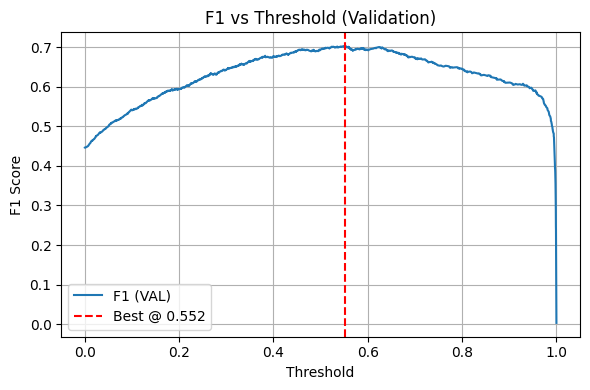

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ Evaluation on TEST @ threshold = 0.552
Confusion Matrix:
 [[1375  142]
 [ 206  404]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8697    0.9064    0.8877      1517
           1     0.7399    0.6623    0.6990       610

    accuracy                         0.8364      2127
   macro avg     0.8048    0.7843    0.7933      2127
weighted avg     0.8325    0.8364    0.8336      2127

ROC-AUC (TEST): 0.879335833234274
PR-AUC / Average Precision (TEST): 0.8105955017762729


In [14]:
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np

# === STEP 1A — Validation probabilities
y_val_proba = model.predict(X_val).ravel()

# === STEP 1B — Best threshold by F1 on VAL
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)  # len(thr) = len(prec)-1
f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = int(np.argmax(f1))
best_thr = float(thr[best_idx])

print(f"🔍 Best F1 (VAL) = {f1[best_idx]:.4f} at threshold = {best_thr:.3f}")
print(f"VAL PR-AUC (Average Precision): {average_precision_score(y_val, y_val_proba):.4f}")

# === STEP 1C — Plot F1 vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thr, f1, label="F1 (VAL)")
plt.axvline(best_thr, color='r', linestyle='--', label=f"Best @ {best_thr:.3f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 vs Threshold (Validation)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) If you prefer a target recall on class 1, uncomment:
# target_recall = 0.70
# idxs = np.where(rec[:-1] >= target_recall)[0]
# if len(idxs):
#     target_thr = float(thr[idxs[-1]])  # smallest thr achieving >= target recall
#     print(f"🎯 Threshold for recall ≥ {target_recall:.2f} (VAL): {target_thr:.3f}")

# === STEP 1D — Evaluate on TEST with chosen threshold
use_thr = best_thr  # or replace with target_thr if you use the target recall approach
y_test_proba = model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= use_thr).astype(int)

print("✅ Evaluation on TEST @ threshold =", round(use_thr, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))
print("ROC-AUC (TEST):", roc_auc_score(y_test, y_test_proba))
print("PR-AUC / Average Precision (TEST):", average_precision_score(y_test, y_test_proba))


model error analysis 

In [3]:
# === Cell S — Static setup (run once) ===
import os, json, time
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass  # ok if not available on your TF build

# Paths
try:
    PROJECT_ROOT  # noqa: F401
except NameError:
    PROJECT_ROOT = Path.cwd()

MODEL_DIR = Path(PROJECT_ROOT) / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def build_model(input_shape, n_classes=1, params=None):
    """
    Builds and compiles a simple 1D-CNN for time x features inputs (e.g., FBank or MFCC).
    Uses two Conv1D blocks, GlobalAveragePooling, a small Dense head, and an output layer.
    """
    tf.keras.backend.clear_session()

    # Defaults + optional overrides
    params = params or {}
    f1 = params.get("f1", 32)
    f2 = params.get("f2", 64)
    k1 = params.get("k1", 5)
    k2 = params.get("k2", 3)
    dense_units = params.get("dense", 64)
    lr = params.get("lr", 1e-3)
    l2_val = params.get("l2", 0.0)
    reg = regularizers.l2(l2_val) if l2_val and l2_val > 0 else None

    m = Sequential([
        layers.Input(shape=input_shape),

        layers.Conv1D(f1, k1, padding="same", activation="relu", kernel_regularizer=reg),
        layers.MaxPooling1D(2),

        layers.Conv1D(f2, k2, padding="same", activation="relu", kernel_regularizer=reg),
        layers.MaxPooling1D(2),

        layers.GlobalAveragePooling1D(),

        layers.Dense(dense_units, activation="relu", kernel_regularizer=reg),

        layers.Dense(
            1 if n_classes == 1 else n_classes,
            activation="sigmoid" if n_classes == 1 else "softmax"
        ),
    ])

    # Compile
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss = "binary_crossentropy" if n_classes == 1 else "sparse_categorical_crossentropy"
    m.compile(
        optimizer=opt,
        loss=loss,
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.AUC(curve="PR", name="auprc"),
        ],
    )
    return m

def compute_cw(y):
    """Balanced class weights from integer labels y."""
    classes = np.array(sorted(np.unique(y)))
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    return {int(c): float(w) for c, w in zip(classes, cw)}

def make_callbacks(run_id):
    """EarlyStopping, ReduceLROnPlateau, and unique checkpoint."""
    ckpt_path = MODEL_DIR / f"best_fbank_1dcnn_{run_id}.keras"
    cbs = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]
    return cbs, ckpt_path


In [10]:
# === Cell R — Train a fresh 1D-CNN with FBank features ===
import json, time
import numpy as np

# 💡 Hyperparameters — simple + overridable
params = {
    "f1": 32,
    "f2": 64,
    "k1": 5,
    "k2": 3,
    "dense": 64,
    "lr": 1e-3,
    "l2": 0.0,   # try 1e-4 if overfitting
}

# ✅ Identify the run clearly as FBank
run_id = time.strftime("fbank_simple_%Y%m%d-%H%M%S")
callbacks, ckpt_path = make_callbacks(run_id)

# 📐 Input shape for model = (time_steps, n_mels)
input_shape = (X_train.shape[1], X_train.shape[2])

# 🔢 Determine output dimensionality
uniq = np.unique(y_train)
# If binary labels {0,1}, use a single sigmoid unit; otherwise use softmax with class count
n_classes = 1 if (uniq.size == 2 and set(uniq).issubset({0, 1})) else int(uniq.size)

# 🏗️ Build a fresh 1D CNN
model = build_model(input_shape, n_classes=n_classes, params=params)
model.summary()

# ⚖️ Compute class weights (works for binary and multiclass with integer labels)
class_weight_dict = compute_cw(y_train)
print("Class weights:", class_weight_dict)
print("Checkpoint path:", ckpt_path)

# 🧾 Show data split info
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train labels:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Val labels:  ", dict(zip(*np.unique(y_val, return_counts=True))))

# 🏋️‍♀️ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# ✅ Evaluate on the test set
test_metrics = model.evaluate(X_test, y_test, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# 💾 Save training history and params
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({
        "history": history.history,
        "params": params,
        "n_classes": n_classes,
        "input_shape": input_shape,
        "test_metrics": dict(zip(model.metrics_names, test_metrics)),
    }, f, indent=2)

print(f"✅ Saved history: {hist_path}")
print(f"✅ Best checkpoint: {ckpt_path}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 32)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 0.7012858555885262, 1: 1.742014742014742}
Checkpoint path: c:\Users\hichr\OneDrive\Desktop\Internship\model\best_fbank_1dcnn_fbank_simple_20250826-121242.keras
Train: (9926, 32, 13) Val: (2127, 32, 13) Test: (2127, 32, 13)
Train labels: {np.int32(0): np.int64(7077), np.int32(1): np.int64(2849)}
Val labels:   {np.int32(0): np.int64(1516), np.int32(1): np.int64(611)}
Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5324 - auc: 0.5484 - auprc: 0.3218 - loss: 0.7931 - val_accuracy: 0.7409 - val_auc: 0.6829 - val_auprc: 0.6036 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5946 - auc: 0.6189 - auprc: 0.4402 - loss: 0.6848 - val_accuracy: 0.6333 - val_auc: 0.6944 - val_auprc: 0.6256 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6535 - auc: 0.6609 - auprc: 0.5349 - loss: 0.6395 - val_accuracy: 0.7677 - val_auc: 0.7048 - val_auprc: 0.6

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔍 Best F1 (VAL) = 0.5108 at threshold = 0.321
VAL PR-AUC (Average Precision): 0.6257


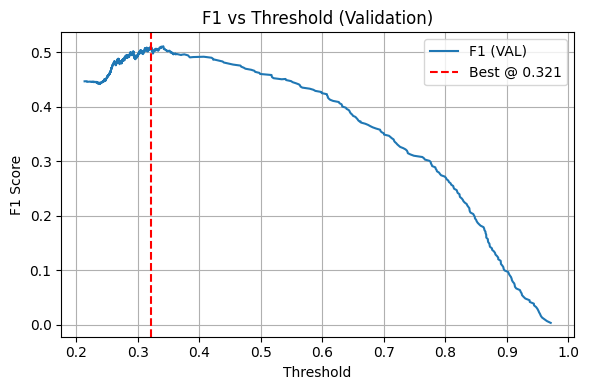

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Evaluation on TEST @ threshold = 0.321
Confusion Matrix:
 [[1416  101]
 [ 381  229]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7880    0.9334    0.8546      1517
           1     0.6939    0.3754    0.4872       610

    accuracy                         0.7734      2127
   macro avg     0.7410    0.6544    0.6709      2127
weighted avg     0.7610    0.7734    0.7492      2127

ROC-AUC (TEST): 0.6720825183440138
PR-AUC / Average Precision (TEST): 0.6007289769924925


In [11]:
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np

# === STEP 1A — Validation probabilities
y_val_proba = model.predict(X_val).ravel()

# === STEP 1B — Best threshold by F1 on VAL
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)  # len(thr) = len(prec)-1
f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = int(np.argmax(f1))
best_thr = float(thr[best_idx])

print(f"🔍 Best F1 (VAL) = {f1[best_idx]:.4f} at threshold = {best_thr:.3f}")
print(f"VAL PR-AUC (Average Precision): {average_precision_score(y_val, y_val_proba):.4f}")

# === STEP 1C — Plot F1 vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thr, f1, label="F1 (VAL)")
plt.axvline(best_thr, color='r', linestyle='--', label=f"Best @ {best_thr:.3f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 vs Threshold (Validation)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) If you prefer a target recall on class 1, uncomment:
# target_recall = 0.70
# idxs = np.where(rec[:-1] >= target_recall)[0]
# if len(idxs):
#     target_thr = float(thr[idxs[-1]])  # smallest thr achieving >= target recall
#     print(f"🎯 Threshold for recall ≥ {target_recall:.2f} (VAL): {target_thr:.3f}")

# === STEP 1D — Evaluate on TEST with chosen threshold
use_thr = best_thr  # or replace with target_thr if you use the target recall approach
y_test_proba = model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= use_thr).astype(int)

print("✅ Evaluation on TEST @ threshold =", round(use_thr, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))
print("ROC-AUC (TEST):", roc_auc_score(y_test, y_test_proba))
print("PR-AUC / Average Precision (TEST):", average_precision_score(y_test, y_test_proba))
